In [3]:
!pip install nlp

In [7]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


In [10]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test (1).txt
Saving train.txt to train (1).txt
Saving val.txt to val (1).txt


In [15]:
import pandas as pd

train = pd.read_csv(
    "train.txt",
    sep=";",
    names=["text","label"])

val = pd.read_csv(
    "val.txt",
    sep=";",
    names=["text","label"])

test = pd.read_csv(
    "test (1).txt",
    sep=";",
    names=["text","label"])

In [16]:
train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [17]:
def get_tweet(data):
    tweets = data["text"]
    labels = data["label"]
    return tweets, labels

In [18]:
tweets, labels = get_tweet(train)
print(tweets[50]," : ", labels[50])

i need to feel the dough to make sure its just perfect  :  joy


In [19]:
def data_description(data):
    shape = data.shape
    text_nulls = data["text"].isnull().sum()
    label_nulls = data["label"].isnull().sum()
    label_count = data["label"].value_counts()

    plt.hist(data["label"])
    plt.xlabel('emotions')
    plt.ylabel('Frequency')
    plt.title('data distribution')

    print("data shape : ",shape)
    print("null values in text field : ", text_nulls)
    print("null values in text field : ", label_nulls)
    print("label counts")
    print(label_count)
    plt.show()

Training data description
data shape :  (16000, 2)
null values in text field :  0
null values in text field :  0
label counts
label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


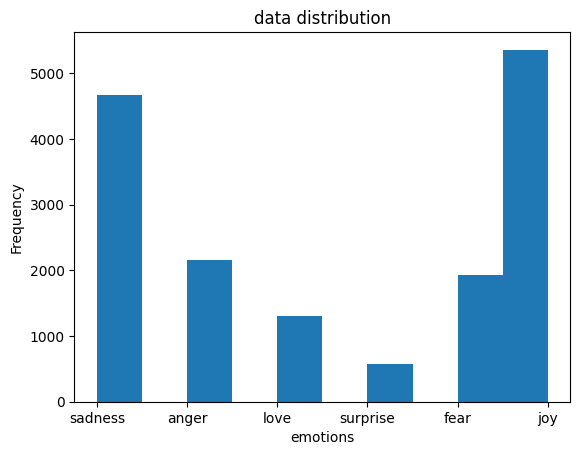

In [20]:
print("Training data description")
data_description(train)

Test data description
data shape :  (2000, 2)
null values in text field :  0
null values in text field :  0
label counts
label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


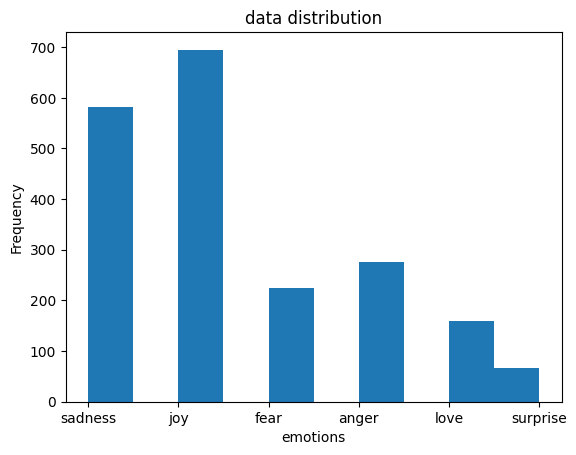

In [21]:
print("Test data description")
data_description(test)

Validation data description
data shape :  (2000, 2)
null values in text field :  0
null values in text field :  0
label counts
label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64


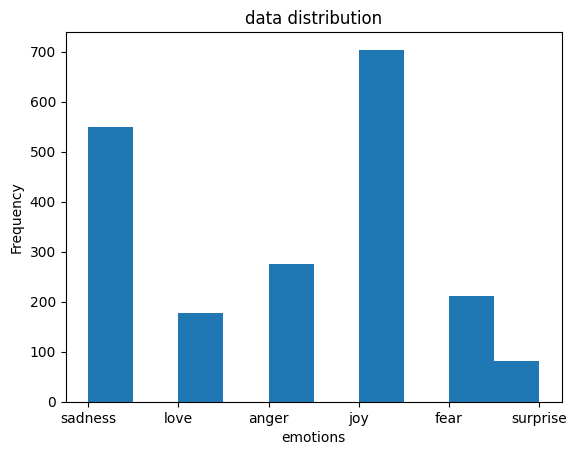

In [22]:
print("Validation data description")
data_description(val)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [24]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [25]:
print(tweets[50])
tokenizer.texts_to_sequences([tweets[50]])

i need to feel the dough to make sure its just perfect


[[2, 105, 5, 3, 6, 7419, 5, 80, 158, 79, 32, 356]]

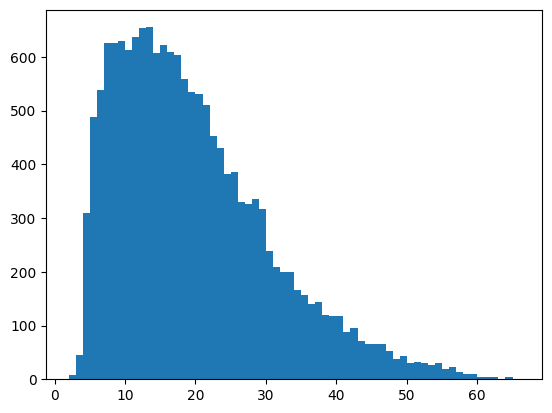

In [26]:
lengths = [len(s.split()) for s in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [27]:
# We notice that most of the tweets have less than 50 words
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
# we need to pad or truncate the sequences to a fixed length, specified by the variable "maxlen".
# This is to ensure that all sequences have the same length, which is necessary for some models to work.
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded_sequences

In [29]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [30]:
padded_train_sequences[50]

array([   2,  105,    5,    3,    6, 7419,    5,   80,  158,   79,   32,
        356,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

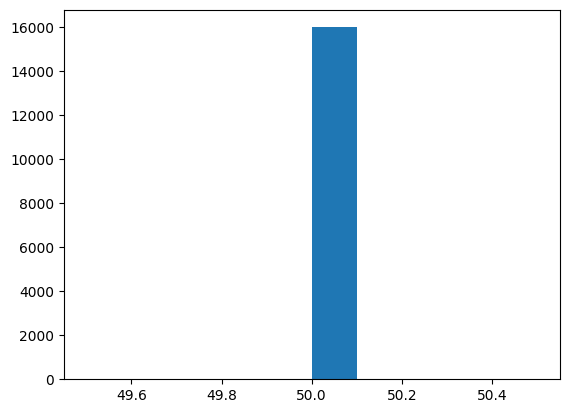

In [31]:
lengths = [len(l) for l in padded_train_sequences]
plt.hist(lengths)
plt.show()

In [32]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [33]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((value,key) for key, value in class_to_index.items())

In [34]:
class_to_index

{'sadness': 0, 'fear': 1, 'joy': 2, 'anger': 3, 'surprise': 4, 'love': 5}

In [35]:
index_to_class

{0: 'sadness', 1: 'fear', 2: 'joy', 3: 'anger', 4: 'surprise', 5: 'love'}

In [36]:
labels_to_ids = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [37]:
ids_to_labels = lambda ids : np.array([index_to_class.get(x) for x in ids])

In [38]:
train_labels = labels_to_ids(labels)
train_labels[50]

np.int64(2)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = labels_to_ids(val_labels)

In [42]:
val_tweets[69], val_labels[69]

('i have no extra money im worried all of the time and i feel so beyond pathetic',
 np.int64(0))

In [43]:
m = model.fit(
    padded_train_sequences,
    train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.3476 - loss: 1.5705 - val_accuracy: 0.5895 - val_loss: 1.1041
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.6494 - loss: 0.9370 - val_accuracy: 0.8060 - val_loss: 0.5824
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.8745 - loss: 0.3849 - val_accuracy: 0.8705 - val_loss: 0.4152
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9334 - loss: 0.2267 - val_accuracy: 0.8825 - val_loss: 0.3669
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.9598 - loss: 0.1346 - val_accuracy: 0.8855 - val_loss: 0.3450
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.9668 - loss: 0.1078 - val_accuracy: 0.8935 - val_loss: 0.3412
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.9752 - loss: 0.0857 - val_accuracy: 0.8885 - val_loss: 0.3993
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9757 - loss: 0.0789 - 

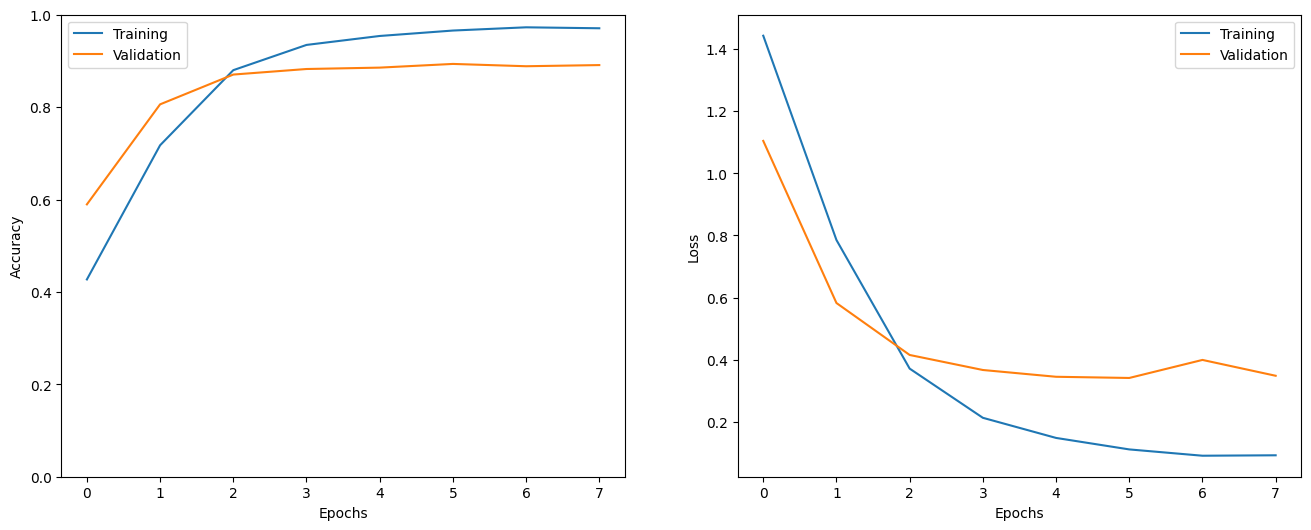

In [45]:
show_history(m)

In [46]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = labels_to_ids(test_labels)

In [47]:
_ = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8820 - loss: 0.3874


In [48]:
for _ in range(5):
    i = random.randint(0, len(test_labels)-1)
    print("Tweet : ", test_tweets[i]," ==> label : ",index_to_class[test_labels[i]])
    p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
    pred_class = index_to_class[np.argmax(p).astype('uint8')]
    print("predicted label : ", pred_class)
    print("-----------------------")

Tweet :  i feel assaulted by this shit storm of confusion anger and hurt feelings that tsunami d us both away from each other  ==> label :  fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
predicted label :  sadness
-----------------------
Tweet :  i also tried after all that frustration when i was feeling none too energetic for more problems to work on the respirometry stuff which is going to be a huge nightmare  ==> label :  joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
predicted label :  joy
-----------------------
Tweet :  i feel so worthless and useless these past weeks just because im a certified by stander at home  ==> label :  sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
predicted label :  sadness
-----------------------
Tweet :  i feel so relaxed and happy when im in the water  ==> label :  joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
predicted label :  joy
-----------------------
Tweet :  i have the joy of allowing kids to feel like the valued treasures that they are and to just have a 

In [49]:
# predictions = model.predict_classes(test_sequences)
predict_x=model.predict(test_sequences)
classes_x=np.argmax(predict_x,axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


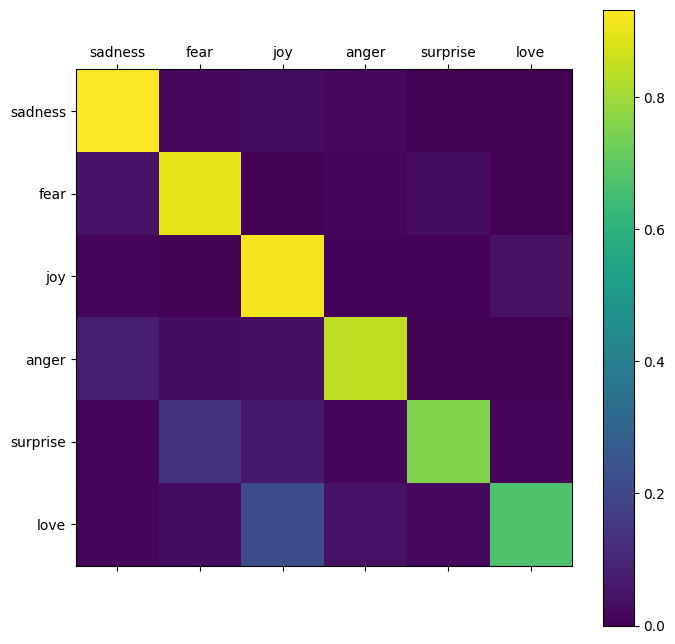

In [50]:
show_confusion_matrix(test_labels, classes_x, list(classes))

# New Section